**Name:** David Björelind

**EID:** 40107147

**Kaggle Team Name:** \_\_\_\_\_

# CS4487 - Assignment 2 - Sound Effects Retrieval
Due date: November 5, 2018, 11:59pm

## Goal
In this assignment, the task is to use a query sound to retrieve the top 10 similar sounds from the training set.  This kind of content-based retrieval system could be useful to musicians and sound engineers who want to find similar sounds in a sound library.


## Methodology
Retrieval is based on finding the documents in the training set that are closest to the query document.  The important thing is how to define the _feature space_ for representing the documents (in this case, audio), and the _distance_ to determine which documents are close.
You are free to choose appropriate methods (e.g., feature extraction method, dimensionality reduction, and clustering methods) to help define a suitable feature space and distance measure between documents.  You are free to use methods that were not introduced in class.  A validation set with a list of ground-truth relevant documents is provided to help development of your method.

## Evaluation of Retrieval

For evaluation, you will predict the top-10 similar training documents for each query.  The evaluation metric is "Mean Average Precision" (MAP@10).  Here is how it is calculated.  For each query, we go through the list of retrieved documents in order from 1st to 10th. When the i-th document is relevant, we calculate the "Precision@i" as "Number relevant documents in top-i" / i.  If the i-th document is not relevant, then the Precision@i is 0.   The "average precision" (AP) is the average of the Precision@i values for i=1..10.
The MAP is the mean AP over all the queries.  Higher values are better.
More information can be found [here](https://www.kaggle.com/wiki/MeanAveragePrecision).


## Evaluation on Kaggle

You need to submit your test retrievals to Kaggle for evaluation.  50% of the test data will be used to show your ranking on the live leaderboard.  After the assignment deadline, the remaining 50% will be used to calculate your final ranking. The entry with the highest final ranking will win a prize!  Also the top-ranked entries will be asked to give a short 5 minute presentation on what they did.

To submit to Kaggle you need to create an account, and use the competition invitation that will be posted on Canvas.

**Note:** You can only submit 2 times per day to Kaggle!


## What to hand in
You need to turn in the following things:

1. This ipynb file `Assignment2-2018.ipynb` with your source code and documentation.  _**You should write about all the various attempts that you make to find a good solution.**_
2. Your final submission file to Kaggle.
3. The ipynb file `Assignment2-2018-Final.ipynb`, which contains the code that generates the final submission file that you submit to Kaggle.  **This code will be used to verify that your Kaggle submission is reproducible.**

Files should be uploaded to Assignment 2 on Canvas.


## Grading
The marks of the assignment are distributed as follows:
- 40% - Results using various feature representations, dimensionality reduction methods, etc.
- 20% - Trying out feature representations (e.g. adding additional features, combining features from different sources) or methods not used in the tutorials.
- 20% - Quality of the written report.  More points for insightful observations and analysis.
- 20% - Final ranking on the Kaggle test data (private leaderboard). If a submission cannot be reproduced by the submitted code, it will not receive marks for ranking.
- **Late Penalty:** 25 marks will be subtracted for each day late.

<hr>

In [1]:
%matplotlib inline
import IPython.core.display         
# setup output image format (Chrome works best)
IPython.core.display.set_matplotlib_formats("svg")
import matplotlib.pyplot as plt
import matplotlib
from numpy import *
from sklearn import *
from scipy import stats
random.seed(100)
import csv
from scipy import io
import pickle
from IPython.display import Audio, display

/Users/davidbjorelind/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/davidbjorelind/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
/Users/davidbjorelind/anaconda3/lib/python3.6/site-packages/sklearn/learning_curve.py:22: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This mod

In [2]:
def showAudio(info):
    display(Audio(info['previews']['preview-lq-mp3']))

def load_pickle(fname):
    f = open(fname, 'rb')
    out = pickle.load(f)
    f.close()
    return out

# Load the Data
The training, validation, and test data are stored in various pickle files.
The below code will load the data.

In [3]:
train_tags = load_pickle('sounds-data/train_tags.pickle3')
train_mfccs = load_pickle('sounds-data/train_mfccs.pickle3')
train_info = load_pickle('sounds-data/train_info.pickle3')

valid_mfccs = load_pickle('sounds-data/val_mfccs.pickle3')
valid_info = load_pickle('sounds-data/val_info.pickle3')
valid_matches = load_pickle('sounds-data/val_matches.pickle3')

test_mfccs = load_pickle('sounds-data/test_mfccs.pickle3')
test_info = load_pickle('sounds-data/test_info.pickle3')

Here are the things in the dataset:

- `train_info` - info about each sound in the training set (contains a link to the sound).
- `train_mfccs` - the MFCC features for each sound in the training set.  MFCCs are [Mel-frequency cepstral coefficients](https://en.wikipedia.org/wiki/Mel-frequency_cepstrum), which are a type of spectral feature vector for audio.
- `train_tags` - the descriptive tags for each sound in the training set. Tags have already been stemmed.
- `valid_info` - info about each sound in the validation set.
- `valid_mfccs` - the MFCC features for each sound in the validation set.
- `valid_matches` - the indicies of matches (to the training set) for each sound in the validation set.
- `test_info` - info about each sound in the test set.
- `test_mfccs` - the MFCC features for each sound in the test.

Here is the first sound in the training set, as well as the tags.

In [4]:
showAudio(valid_info[10])
print(valid_matches[10])
print("---")
showAudio(train_info[2084])
print(train_tags[2084])
showAudio(train_info[2091])
print(train_tags[2091])
showAudio(train_info[2088])
print(train_tags[2088])


[2084, 2091, 2088, 2090, 2086, 2092, 2083, 2085, 2089, 2087]
---


groovebox electrib drum beat korg fat factori bassdrum preset kickdrum new percuss emx kick bass


bassdrum drum bass beat electrib korg fat factori groovebox preset kickdrum new percuss emx kick sub


bassdrum drum bass beat electrib korg fat factori groovebox preset kickdrum new percuss emx kick sub


and here are the MFCCs for the first sound in the training set.  The MFCC vectors are 13-dimensions each, and they are extracted using a sliding window over the sound.

(176, 13)


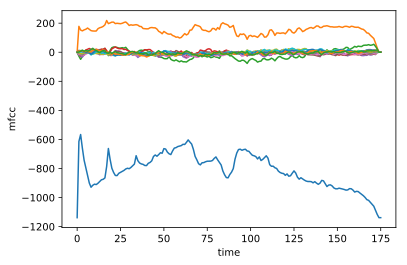

In [5]:
print(train_mfccs[1].shape)
plt.plot(train_mfccs[1]);
plt.xlabel('time')
plt.ylabel('mfcc');

## Data Pre-processing - Delta MFCCs

The first thing you might notice is that the MFCC vectors are time-series.  One trick to include time-series information into a vector representation is to append the difference between two consecutive feature vectors.  This way, we can include some relationship between two time steps in the representation.

In [6]:
# compute delta MFCCs
def compute_delta_mfccs(mfccs):
    dmfccs = []
    for m in mfccs:
        tmp = m[1:] - m[0:-1]
        dm = hstack((m[0:-1], tmp))
        dmfccs.append(dm)
    return dmfccs

In [7]:
train_dmfccs = compute_delta_mfccs(train_mfccs)
test_dmfccs  = compute_delta_mfccs(test_mfccs)
valid_dmfccs = compute_delta_mfccs(valid_mfccs)

In [8]:
print(len(train_dmfccs))
print(len(train_dmfccs[3]))

print(train_dmfccs[0][0])
print(train_dmfccs[12].shape)

2492
319
[-1.08599561e+03  6.16124954e+01  3.26212196e+01  4.88774490e+00
 -9.12226868e+00 -8.47605133e+00 -7.11513519e-01  4.72403717e+00
  3.38615799e+00 -1.22250366e+00 -2.96123886e+00 -7.83477783e-01
  1.45116425e+00  4.25331665e+02  4.10426712e+01  2.63916092e+01
  2.21846256e+01  1.22690163e+01  5.83558960e+01 -2.38054867e+01
  3.96332779e+01 -1.63995991e+01  1.71343832e+01  1.39941864e+01
 -2.17901421e+00  1.58920860e+01]
(22, 26)


## Data Pre-processing - bag-of-words

The next problem you might notice is that the number of MFCCs is different for each sound, since sound can have different lengths.  Hence, before using our machine learning algorithms, we need to encode the MFCCs into a vector.

One solution is to use a "bag-of-audio-words" representation, which is analogous to the bag-of-words representation for text.
Here, we build a vocabulary of "audio-words" and map each MFCC to one of the words.  Then we can represent each sound as a histogram of counts.

We will use the k-means clustering algorithm to build the codebook of audio words.  .

In [9]:
# put dmfccs from all training data together
all_dmfccs = vstack(train_dmfccs)
print(all_dmfccs.shape)

(600481, 26)


In [11]:
# run k-means to build codebook
km = cluster.KMeans(n_clusters=100, random_state=4487)
km.fit(all_dmfccs[0::10])  # subsample by 10 to make it faster
km.cluster_centers_

array([[-9.60116185e+02,  6.13341315e+01, -6.53537995e+01, ...,
         7.46929769e-01,  3.73115866e-01,  2.55179442e-01],
       [-7.68894461e+02,  1.62352902e+02,  1.15202892e+02, ...,
        -1.31942654e-01, -1.88046455e-01, -1.88083076e-01],
       [-7.50638341e+02,  1.63085041e+02, -2.34155533e+01, ...,
         1.85378547e-01,  1.25150496e-02,  2.75911644e-01],
       ...,
       [-5.06251280e+02,  7.06551832e+01, -2.42345038e+00, ...,
         2.34139366e+00, -1.87286341e-01,  8.57677623e-01],
       [-7.32319229e+02,  1.41691327e+02,  2.69263484e+01, ...,
        -3.51432426e-01, -2.40535901e-01, -2.44335419e-01],
       [-8.48405526e+02,  1.62195084e+02,  2.04368721e+01, ...,
        -2.36987360e+00,  6.21039521e-01, -1.00944469e+00]])

Now transform the data into BOW.

In [10]:
def bow_transform(model, mfccs):
    numwords = model.cluster_centers_.shape[0]
    bows = zeros((len(mfccs), numwords))
    for i in range(len(mfccs)):
        w = model.predict(mfccs[i])
        bw = bincount(w, minlength=numwords)
        bows[i,:] = bw
    return bows

def bow_transform_gmm(model, mfccs):
    numwords = model.means_.shape[0]
    bows = zeros((len(mfccs), numwords))
    for i in range(len(mfccs)):
        w = model.predict(mfccs[i])
        bw = bincount(w, minlength=numwords)
        bows[i,:] = bw
    return bows

def bow_transform_sc(model, mfccs):
    numwords = model.labels_.shape[0]
    bows = zeros((len(mfccs), numwords))
    for i in range(len(mfccs)):
        w = model.predict(mfccs[i])
        bw = bincount(w, minlength=numwords)
        bows[i,:] = bw
    return bows

In [32]:
train_bow = bow_transform(km, train_dmfccs)
test_bow  = bow_transform(km, test_dmfccs)
valid_bow = bow_transform(km, valid_dmfccs)

ValueError: Incorrect number of features. Got 26 features, expected 8

## Baseline experiments

Next, we will run a baseline experiment doing retrieval with bag-of-audio words.

Here are some useful functions for nearest neighbor retrieval, computing MAP@10 for evaluation, and saving the Kaggle submission file.

In [11]:
def nn_retr(testX, trainX):
    # do retrieval using nearest neighbors
    # for each entry in testX, find the top 10 closest entries in trainX using Euclidean distance
    
    test_retr = []  # retrieval list

    # for each test document vector
    for tX in testX:
        # calculate the distance between tX and all training document vectors
        # (using Euclidean distance)
        if tX.ndim == 1:
            ttX = tX.reshape((1,tX.shape[0]))
        else:
            ttX = tX;
        D = metrics.pairwise_distances(ttX, trainX, metric='euclidean')
        Df = D.flatten()
        
        # find the 10 with smallest distance
        # (faster: bestmatches are the top-10, but not sorted yet)
        bestmatches_unsorted = argpartition(Df, 10)[0:10]
                
        # now sort bestmatches
        bestmatches_tmp = argsort(Df[bestmatches_unsorted])
        bestmatches = bestmatches_unsorted[bestmatches_tmp]        
        
        # slow, since it sorts everything
        #bestmatches = argsort(D.flatten())[0:10]
    
        # add to retrieval list
        test_retr.append(bestmatches)

    return test_retr

In [12]:
def calc_MAP(Ytrue, Ypred, K=10):
    # calculate the mean average precision
    # returns the MAP for the whole set, and the AP for each document
    
    AP = zeros(len(Ytrue))
    # for each document
    for j in range(len(Ytrue)):
        Yt = Ytrue[j]
        if not isinstance(Yt, ndarray):
            Yt = array([Yt])
        Yp = Ypred[j]
        # calculate average precision @ K
        nummatches = 0.
        score = 0.
        for i,y in enumerate(Yp[0:K]):
            # if match at this level, calculate P
            if any(y==Yt):
                nummatches += 1.
                P = nummatches / (i+1)
                score += P
        AP[j] = score / K #min(K, len(Yt))

    # mean over all documents
    MAP = mean(AP)
    return (MAP, AP)

# write a kaggle submission file for retrieval
def write_csv_kaggle_retr_sub(fname, Yretr):
    # header
    tmp = [['Id', 'RetrievedDocuments']]
    
    # add ID numbers for each Y, and usage if necessary
    for i in range(len(Yretr)):
        y = Yretr[i]
        ystr = [str(q) for q in y]
        tmp2 = [str(i+1)]
        tmp2.append(" ".join(ystr))        
        tmp.append(tmp2)
        
    # write CSV file
    f = open(fname, 'w')
    writer = csv.writer(f)
    writer.writerows(tmp)
    f.close()

Next, apply TF-IDF to the count vectors.

In [16]:
# convert to TF
tf_trans = feature_extraction.text.TfidfTransformer(use_idf=True, norm='l1')
train_Xtf = tf_trans.fit_transform(train_bow)
test_Xtf  = tf_trans.transform(test_bow)
valid_Xtf = tf_trans.transform(valid_bow)

Now do the retrieval on the validation set and test set.

In [17]:
# do retrieval
test_retr = nn_retr(test_Xtf, train_Xtf)
val_retr  = nn_retr(valid_Xtf, train_Xtf)

We can evaluate on the validation set using the provided matches. The plot shows the histogram of Average precision (AP@10) for the query sounds in the validation set, as well as the overall MAP.

0.11026467868700877


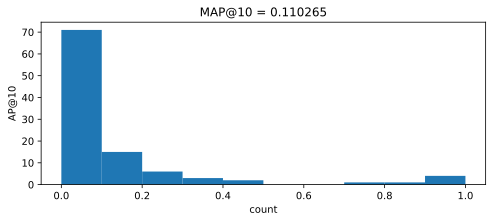

In [18]:
# evaluate on the validation set with P@10
vMAP,vAP = calc_MAP(valid_matches, val_retr)

print(vMAP)
plt.figure(figsize=(8,3))
plt.hist(vAP)
plt.title('MAP@10 = %g' % (vMAP,))
plt.xlabel('count')
plt.ylabel('AP@10');

Now write the retrieval results for the test set for submission to Kaggle.

In [19]:
write_csv_kaggle_retr_sub("sounds_test_kaggle_bow_baseline.csv", test_retr)

In this baseline method we didn't use the tags that come with the training set.  The retrieval is completely unsupervised, and we are hoping that our feature space is perfectly good for retrieval.

One idea is to build another feature space based on the tags, which we call a "semantic space".  First, build classifiers for each tag (tag or not-tag). Then for each song, use the tag predictions (or tag probabilites) as the new feature vector.

## YOUR CODE and DOCUMENTATION HERE

Going into this, I feel like the assignment is overwhelming, but I am going to do my best to complete it.

Let's start by trying to use Mean-shift algorith.

We have:
- train_Xtf as trainX
- valid_Xtf as trainY
- test_Xtf  as testX, which is finally going to be tested and submitted to kaggle

Procedure is:
- Build codebook using a specific method
- Transform data into BOW
- Convert to TP
- Do retrieval
- Evaluate on the validation set

This took a very long time to compute... Also the results were way worse than the Baseline experiment.
I also tried another method for clustering, but also with very long computation time...

Continuing by trying to use a dimentionality reduction method...

In [20]:


km = cluster.KMeans(n_clusters=150, random_state=4487)
km.fit(all_dmfccs[0::10])  # subsample by 10 to make it faster
km.cluster_centers_
print("here")
# creating BOW
train_bow = bow_transform(km, train_dmfccs)
test_bow  = bow_transform(km, test_dmfccs)
valid_bow = bow_transform(km, valid_dmfccs)
# convert to TF
tf_trans = feature_extraction.text.TfidfTransformer(use_idf=True, norm='l1')
train_Xtf = tf_trans.fit_transform(train_bow)
test_Xtf  = tf_trans.transform(test_bow)
valid_Xtf = tf_trans.transform(valid_bow)
# do retrieval
test_retr = nn_retr(test_Xtf, train_Xtf)
val_retr  = nn_retr(valid_Xtf, train_Xtf)
# evaluate on the validation set with P@10
vMAP,vAP = calc_MAP(valid_matches, val_retr)
print(vMAP)
plt.figure(figsize=(8,3))
plt.hist(vAP)
plt.title('MAP@10 = %g' % (vMAP,))
plt.xlabel('count')
plt.ylabel('AP@10');
write_csv_kaggle_retr_sub("davidbjorelind3.csv", test_retr)





KeyboardInterrupt: 

This only made the baseline experiment slightly better with different parameters

In [13]:
def transform_back(mfccs_old, mfccs_new):
    res = []
    count = 0
    
    for i in range(len(mfccs_old)):
        l = len(mfccs_old[i][0:])
        res.append(mfccs_new[count:(count+l)])
        count = count + l
        
    return res

(600481, 26)
(600481, 8)
0.026051779935275084


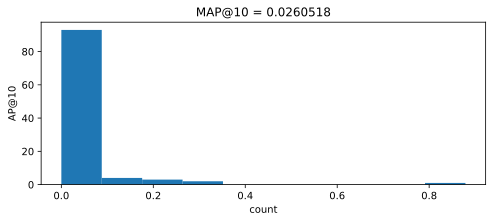

In [19]:
## PCA: The simplest dimentionality reduction method
print(all_dmfccs.shape) # 26 dimensions before
 # PCA
pca = decomposition.PCA(n_components=8)
w_8 = pca.fit_transform(all_dmfccs)
    

train_dmfccs_r = vstack(train_dmfccs)
test_dmfccs_r = vstack(test_dmfccs)
valid_dmfccs_r = vstack(valid_dmfccs)

train_dmfccs_8 = pca.transform(train_dmfccs_r)
test_dmfccs_8 = pca.transform(test_dmfccs_r)
valid_dmfccs_8 = pca.transform(valid_dmfccs_r)
print(w_8.shape) # 8 now

#Transform
train_dmfccs_8_back = transform_back(train_dmfccs, train_dmfccs_8)
test_dmfccs_8_back = transform_back(test_dmfccs, test_dmfccs_8)
valid_dmfccs_8_back = transform_back(valid_dmfccs, valid_dmfccs_8)

#km = cluster.KMeans(n_clusters=100, random_state=4487)
#km.fit(w_8[0::5]) ## consider [0::10]
#km.cluster_centers_

# run k-means to build codebook
ms = cluster.MeanShift(bandwidth=5, bin_seeding=True, n_jobs=-1)
ms.fit(w_8[0::10])  # subsample by 10 to make it faster
ms.cluster_centers_

train_bow = bow_transform(ms, train_dmfccs_8_back)
test_bow  = bow_transform(ms, test_dmfccs_8_back)
valid_bow = bow_transform(ms, valid_dmfccs_8_back)

# convert to TF
tf_trans = feature_extraction.text.TfidfTransformer(use_idf=True, norm='l1')
train_Xtf = tf_trans.fit_transform(train_bow)
test_Xtf  = tf_trans.transform(test_bow)
valid_Xtf = tf_trans.transform(valid_bow)

test_retr = nn_retr(test_Xtf, train_Xtf)
val_retr  = nn_retr(valid_Xtf, train_Xtf)

# evaluate on the validation set with P@10
vMAP,vAP = calc_MAP(valid_matches, val_retr)

print(vMAP)
plt.figure(figsize=(8,3))
plt.hist(vAP)
plt.title('MAP@10 = %g' % (vMAP,))
plt.xlabel('count')
plt.ylabel('AP@10');

Finally, I make made my first dimesionality reduction. Unfortunately, it was only half as good as the baseline...

I am not sure whether of not this was successful or not. There might be some things faulty...

Proceeding in trying different classifiers and parameters, but still dimention reduction

(600481, 26)
(600481, 5)


/Users/davidbjorelind/anaconda3/lib/python3.6/site-packages/sklearn/mixture/base.py:237: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


0.0023705501618122974


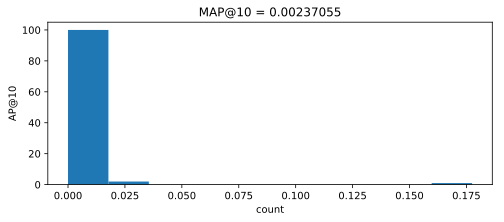

In [27]:
 ## Trying another classifier: 
    
print(all_dmfccs.shape) # 26 dimensions before
 # PCA
pca = decomposition.PCA(n_components=5)
w_8 = pca.fit_transform(all_dmfccs)
print(w_8.shape) # 8 now

train_dmfccs_r = vstack(train_dmfccs)
test_dmfccs_r = vstack(test_dmfccs)
valid_dmfccs_r = vstack(valid_dmfccs)

train_dmfccs_8 = pca.fit_transform(train_dmfccs_r)
test_dmfccs_8 = pca.fit_transform(test_dmfccs_r)
valid_dmfccs_8 = pca.fit_transform(valid_dmfccs_r)

#Transform
train_dmfccs_8_back = transform_back(train_dmfccs, train_dmfccs_8)
test_dmfccs_8_back = transform_back(test_dmfccs, test_dmfccs_8)
valid_dmfccs_8_back = transform_back(valid_dmfccs, valid_dmfccs_8)

alpha = 20
gmm = mixture.BayesianGaussianMixture(covariance_type='diag', weight_concentration_prior=alpha, n_components=100, max_iter=100,                                        random_state=4487)
gmm.fit(w_5[0::100])
#gmm.cluster_centers_


train_bow = bow_transform_gmm(gmm, train_dmfccs_8_back)
test_bow  = bow_transform_gmm(gmm, test_dmfccs_8_back)
valid_bow = bow_transform_gmm(gmm, valid_dmfccs_8_back)

test_retr = nn_retr(test_Xtf, train_Xtf)
val_retr  = nn_retr(valid_Xtf, train_Xtf)

# evaluate on the validation set with P@10
vMAP,vAP = calc_MAP(valid_matches, val_retr)

print(vMAP)
plt.figure(figsize=(8,3))
plt.hist(vAP)
plt.title('MAP@10 = %g' % (vMAP,))
plt.xlabel('count')
plt.ylabel('AP@10');

Okay, this performed just like the previous one with k-means...
I guess that dimension reduction removes some accuracy in order for the process to be faster. I don't know however how to increase the accuary.

Trying another dimension reduction method: LSA



(600481, 8)
0.1083626136538758


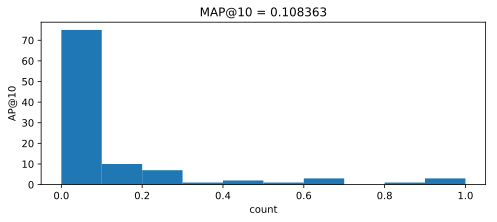

In [17]:
#3 Using LSA as dimention reduction method

lsa = decomposition.TruncatedSVD(n_components=8, random_state=4487)
wlsa = lsa.fit_transform(all_dmfccs)


train_dmfccs_r = vstack(train_dmfccs)
test_dmfccs_r = vstack(test_dmfccs)
valid_dmfccs_r = vstack(valid_dmfccs)

train_dmfccs_8 = lsa.transform(train_dmfccs_r)
test_dmfccs_8 = lsa.transform(test_dmfccs_r)
valid_dmfccs_8 = lsa.transform(valid_dmfccs_r)
print(wlsa.shape) # 8 now

#Transform
train_dmfccs_8_back = transform_back(train_dmfccs, train_dmfccs_8)
test_dmfccs_8_back = transform_back(test_dmfccs, test_dmfccs_8)
valid_dmfccs_8_back = transform_back(valid_dmfccs, valid_dmfccs_8)

km = cluster.KMeans(n_clusters=100, random_state=4487)
km.fit(wlsa[0::10]) ## consider [0::10]
km.cluster_centers_


train_bow = bow_transform(km, train_dmfccs_8_back)
test_bow  = bow_transform(km, test_dmfccs_8_back)
valid_bow = bow_transform(km, valid_dmfccs_8_back)

# convert to TF
tf_trans = feature_extraction.text.TfidfTransformer(use_idf=True, norm='l1')
train_Xtf = tf_trans.fit_transform(train_bow)
test_Xtf  = tf_trans.transform(test_bow)
valid_Xtf = tf_trans.transform(valid_bow)

test_retr = nn_retr(test_Xtf, train_Xtf)
val_retr  = nn_retr(valid_Xtf, train_Xtf)

# evaluate on the validation set with P@10
vMAP,vAP = calc_MAP(valid_matches, val_retr)

print(vMAP)
plt.figure(figsize=(8,3))
plt.hist(vAP)
plt.title('MAP@10 = %g' % (vMAP,))
plt.xlabel('count')
plt.ylabel('AP@10');

This combination of methods produced the same result...
I proceed by trying yet another clustering method.
Spectral Clustering should perform better as it is better at finding clusters in complex shapes.

In [ ]:
## PCA: The simplest dimentionality reduction method
print(all_dmfccs.shape) # 26 dimensions before
 # PCA
pca = decomposition.PCA(n_components=8)
w_8 = pca.fit_transform(all_dmfccs)
    

train_dmfccs_r = vstack(train_dmfccs)
test_dmfccs_r = vstack(test_dmfccs)
valid_dmfccs_r = vstack(valid_dmfccs)

train_dmfccs_8 = pca.fit_transform(train_dmfccs_r)
test_dmfccs_8 = pca.fit_transform(test_dmfccs_r)
valid_dmfccs_8 = pca.fit_transform(valid_dmfccs_r)
print(w_8.shape) # 8 now

#Transform
train_dmfccs_8_back = transform_back(train_dmfccs, train_dmfccs_8)
test_dmfccs_8_back = transform_back(test_dmfccs, test_dmfccs_8)
valid_dmfccs_8_back = transform_back(valid_dmfccs, valid_dmfccs_8)


# run Spectral Clustering to make BOW
gamma = 1.2
sc = cluster.SpectralClustering(n_clusters=4, affinity='rbf', 
                                    gamma=gamma, assign_labels='discretize', n_jobs=-1, random_state=4487)
Y = sc.fit_predict(w_8[0::10])

train_bow = bow_transform_sc(sc, train_dmfccs_8_back)
test_bow  = bow_transform_sc(sc, test_dmfccs_8_back)
valid_bow = bow_transform_sc(sc, valid_dmfccs_8_back)

# convert to TF
tf_trans = feature_extraction.text.TfidfTransformer(use_idf=True, norm='l1')
train_Xtf = tf_trans.fit_transform(train_bow)
test_Xtf  = tf_trans.transform(test_bow)
valid_Xtf = tf_trans.transform(valid_bow)

test_retr = nn_retr(test_Xtf, train_Xtf)
val_retr  = nn_retr(valid_Xtf, train_Xtf)

# evaluate on the validation set with P@10
vMAP,vAP = calc_MAP(valid_matches, val_retr)

print(vMAP)
plt.figure(figsize=(8,3))
plt.hist(vAP)
plt.title('MAP@10 = %g' % (vMAP,))
plt.xlabel('count')
plt.ylabel('AP@10');

(600481, 26)
(600481, 8)


In [ ]:
What I have done is to try different dimention reduction methods in combination with different clustering methods.
This has, however, not produced more accurate results than the baseline testing.
I have been very frustrated with this assignment, really trying to make changes to my methods in the right direction.
Without any success, unfortunately.

Therefore, the best submission I can make is the same as the baseline method with some small changes in parameters.